In [10]:
import numpy as np
from matplotlib import cm, pyplot as plt

# 1
## a)

In [11]:
def central_difference_matrix(M, N, d):
    """
    :param M: number of grid points along the x-axis
    :param N: number of grid points along the y-axis
    :param d: direction
    :return: Central difference matrix approximating twice derivative along d
    """

    x, y = d

    offset = (M-1) * y + x

    A = -2 * np.eye((N-1)*(M-1))

    off_diag = np.ones((N-1)*(M-1)-offset)
    if x:
        off_diag[M-2::M-1] = 0
    A += np.diag(off_diag, k=offset) + np.diag(off_diag, k=-offset)

    return A

In [12]:
def boundary_conditions(g, a, M, N, x, y):
    """

    Adjust rhs wrt boundary. Fattens bndry if Nk≠2.

    :param g: g=(g0, g1, g2, g3) tuple of functions defined on the boundary
    :param x: array from 0 to 1 of size M+1
    :param y: array from 0 to 2 of size N+1
    :return: adjustments to the rhs for elements close to the boundary
    """
    g0, g1, g2, g3 = g
    rhs = np.zeros((N-1, M-1))

    # Adjust for derivative along d1
    rhs[:, 0] += a*g1(y[1:-1])  # Left
    rhs[:, -1] += a*g2(y[1:-1])  # Right

    # Adjust for derivative along d2
    rhs[0, :] += g0(x[:-2])  # Bottom
    rhs[-1, :] += g3(x[2:])  # Top
    rhs[1:, 0] += g1(y[1:-2])  # Left, skip first entry to avoid overlap with bottom
    rhs[:-1, -1] += g2(y[2:-1])  # Right, skip last entry to avoid overlap with top

    return rhs.reshape((N-1)*(M-1))

In [13]:
def solve(a, d, g, f, r, M, N=None):
    """
    :param d: tuple of vectors (d1, d2) specifying the direction of the heat flows
    :param g: g=(g0, g1, g2, g3) tuple of functions defined on the boundary
    :param f: rhs of the analytic equation
    :return: meshgrid (X, Y) and numeric solution u on the interior
    """

    if N is None:
        N = M

    x, h = np.linspace(0, 1, M+1, retstep=True)
    y = np.linspace(0, r*h*N, N+1)  # Fattens the bndry if kN≠2

    X, Y = np.meshgrid(x[1:-1], y[1:-1])

    d1, d2 = d
    A = - a*central_difference_matrix(M, N, d1)/h**2-central_difference_matrix(M, N, d2)/h**2
    rhs = f(X, Y).reshape((N-1)*(M-1))
    rhs += boundary_conditions(g, a, M, N, x, y)/h**2

    u = np.linalg.solve(A, rhs).reshape((N-1, M-1))

    return X, Y, u

In [18]:
def subplots_3d(nrows=1, ncols=1, **fig_kw):
    return plt.subplots(nrows, ncols, subplot_kw={"projection": "3d"}, **fig_kw)


def plot_solution(X, Y, u, ax=None, txt='Solution'):
    # Plot the solution of the stationary heat equation

    if ax is None:
        _, ax = subplots_3d()

    ax.plot_surface(X, Y, u, cmap=cm.coolwarm)
    ax.view_init(azim=30)  # Rotate the figure
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(txt)

In [15]:
def boundaries(T):
    def g0(x):  # Bottom
        return T(x, 0)

    def g1(y):  # Left
        return T(0, y)

    def g2(y):  # Right
        return T(1, y)

    def g3(x):  # Top
        return T(x, 2)

    return g0, g1, g2, g3

In [16]:
def T1(x, y):
    return np.exp(-x-1/2*y)

def f1(x, y):
    return -(r + a+1 + 0.25*r**2) * T1(x, y)

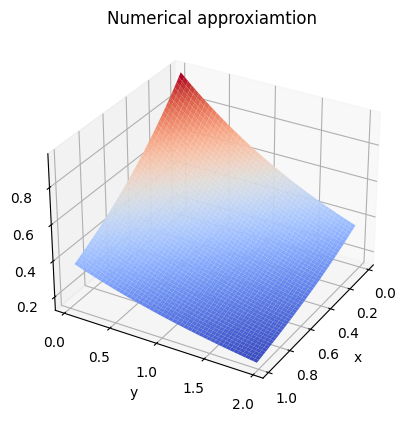

In [31]:
a = 1.3
r = 2
d1 = (1, 0)
d2 = (1, 1)  # Adjusted after the grid, taking r into account (is actually (1, r))
d = d1, d2

M = 50

g = boundaries(T1)
X, Y, u = solve(a, d, g, f1, r, M)

plot_solution(X, Y, u, txt="Numerical approxiamtion")

In [27]:
def T2(x, y):
    return 0.5 * x * (1-x)

def f2(x, y):
    return np.full_like(x, a + 1)

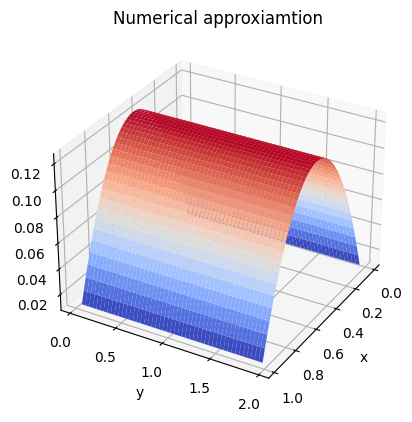

In [32]:
g = boundaries(T2)
X, Y, u = solve(a, d, g, f2, r, M)

plot_solution(X, Y, u, txt="Numerical approxiamtion")

## c)

In [33]:
def loglogplot_error(h, e, ax=None):

    if ax is None:
        _, ax = plt.subplots()

    p = np.polyfit(np.log(h), np.log(e), 1)[0]

    ax.set_title("Error")
    ax.loglog(h, e, label=f"p={p:.3f}")
    ax.set_xlabel("h")
    ax.set_ylabel("e")
    ax.invert_xaxis()
    plt.legend()
    return plt

For the analytic solution
$$
T_2(x, y) = \frac{1}{2} x (1-x)
$$
we expect no/machine error

<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

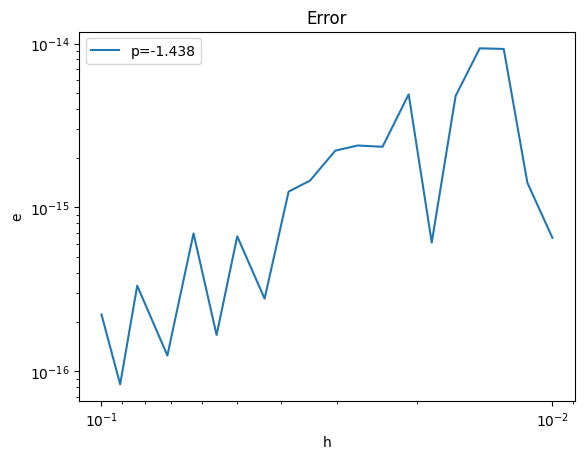

In [37]:
M = np.logspace(1, 2, 20, dtype=int)
h = 1/M
e = np.empty_like(h)

g = boundaries(T2)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f2, r, M[i])
    e[i] = np.max(np.abs(u-T2(X, Y)))

loglogplot_error(h, e)

For any other function, we expect it to be a function of $h^2$:

<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

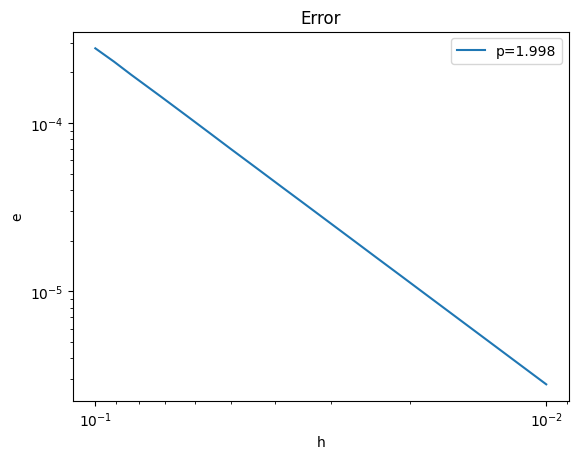

In [38]:
M = np.logspace(1, 2, 20, dtype=int)
h = 1/M
e = np.empty_like(h)
g = boundaries(T1)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f1, r, M[i])
    e[i] = np.max(np.abs(u-T1(X, Y)))

loglogplot_error(h, e)

In [39]:
def T3(x, y):
    return np.sin(0.5*np.pi*y)

def f3(x, y):
    return 1 / 4 *r**2* np.pi**2 *np.sin(1 / 2 *np.pi* y)

<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

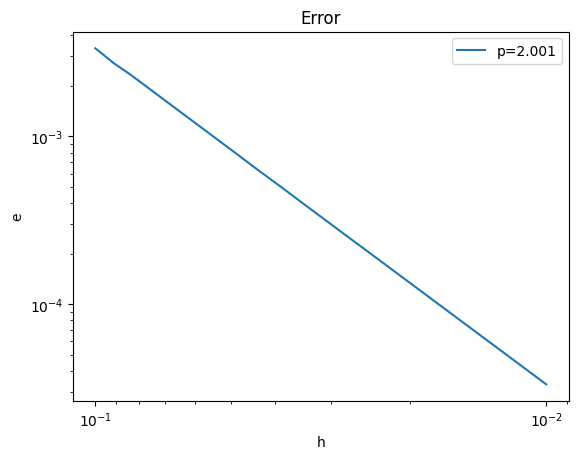

In [41]:
g = boundaries(T3)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f3, r, M[i])
    e[i] = np.max(np.abs(u-T3(X, Y)))

loglogplot_error(h, e)

## d)

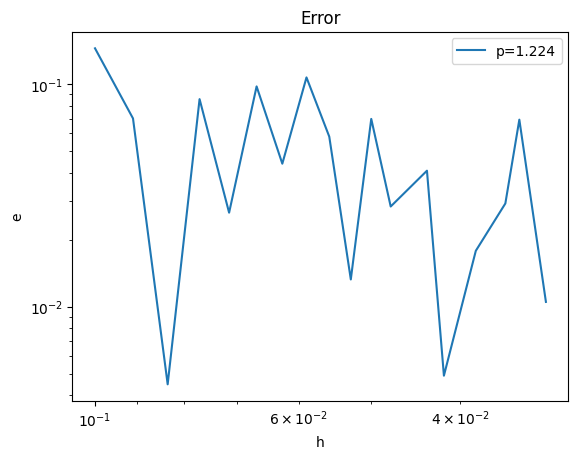

In [44]:
r = np.sqrt(2)

g = boundaries(T3)

M = np.logspace(1, 1.5, 20, dtype=int)
N = np.array(2*M/r, dtype=int) + 1
h = 1/M
e = np.empty_like(h)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f3, r, M[i], N[i])
    e[i] = np.max(np.abs(u-T3(X, Y)))

loglogplot_error(h, e).show()

While, again for $T_2$, we get machine error:

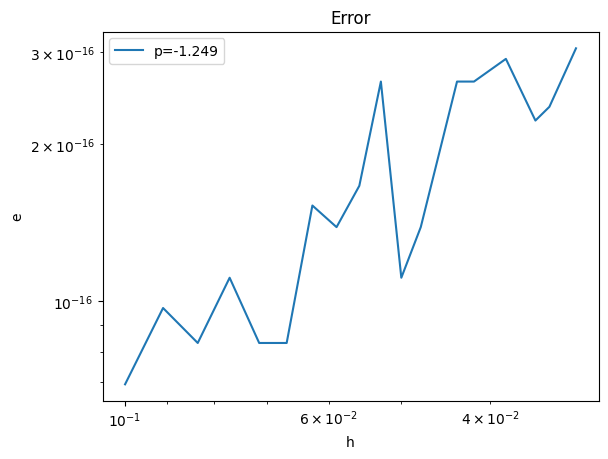

In [45]:
r = np.sqrt(2)

g = boundaries(T2)

M = np.logspace(1, 1.5, 20, dtype=int)
N = np.array(2*M/r, dtype=int) + 1
h = 1/M
e = np.empty_like(h)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f2, r, M[i], N[i])
    e[i] = np.max(np.abs(u-T2(X, Y)))

loglogplot_error(h, e).show()